In [2]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy import constants as const
import astropy.units as u
from matplotlib.ticker import FuncFormatter

# remove this line if you installed platypos with pip
sys.path.append('/media/laura/SSD2lin/Dropbox/PhD_2/Python_Projects/PLATYPOS/platypos/')
from platypos import Planet_LoFo14
from platypos import Planet_ChRo16
from platypos import Planet_Ot20
import platypos.planet_models_LoFo14 as plmoLoFo14
import platypos.planet_models_ChRo16 as plmoChRo16
import platypos.planet_model_Ot20 as plmoOt20

from platypos.mass_loss_rate_function import mass_loss_rate, mass_loss_rate_RRlim, mass_loss_rate_Elim, mass_loss_rate_HBA
from platypos.lx_evo_and_flux import flux_at_planet_earth, l_xuv_all, flux_at_planet, lx_evo
from platypos.lx_evo_and_flux import calculate_EUV_luminosity_Linsky13_15

sys.path.append('/media/laura/SSD2lin/Dropbox/PhD_2/Python_Projects/PLATYPOS/multitrack/')
import multitrack.keplers_3rd_law as kepler3

# # import the classes with fixed step size for completeness
# from platypos.planet_LoFo14_PAPER import Planet_LoFo14_PAPER
# from platypos.planet_Ot20_PAPER import Planet_Ot20_PAPER

%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


# Mass-loss rate calculations

In [3]:
L_bol, mass_star, radius_star = 1., 1., 1.
age_star = 10. # Myr
Lx_age = Lx_chandra = 1.3e30  # erg/s in energy band: (0.1-2.4 keV)

#age_star = 5e3 # Myr
#Lx_age = Lx_chandra = 1.65*10**27  # erg/s in energy band: (0.1-2.4 keV)


# use dictionary to store star-parameters
star = {'star_id': 'dummy', 'mass': mass_star,
        'radius': radius_star, 'age': age_star,
        'L_bol': L_bol, 'Lx_age': Lx_age}

Lx_1Gyr, Lx_5Gyr = 2.10*10**28, 1.65*10**27
track_low = {"t_start": star["age"], "t_sat": star["age"],
             "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age, 
             "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 20.,
             "Lx_drop_factor": 16.}
track_med = {"t_start": star["age"], "t_sat": star["age"],
             "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age,
             "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0.,
             "Lx_drop_factor": 0.}
track_high = {"t_start": star["age"], "t_sat": 240., "t_curr": 1000.,
              "t_5Gyr": 5000., "Lx_max": Lx_age, "Lx_curr": Lx_1Gyr,
              "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0., "Lx_drop_factor": 0.}


# # Ot20 planet
# planet = {"radius": 4.0,
#           "distance": 0.5}
# pl = Planet_Ot20(star, planet)
# print(type(pl))
# print(isinstance(pl, Planet_Ot20))
# print(pl.radius, pl.mass)
# planet = {"mass": 11.0,
#           "distance": 0.5}
# pl = Planet_Ot20(star, planet)
# print(type(pl))
# print(isinstance(pl, Planet_Ot20))
# print(pl.radius, pl.mass)

# LoFo14 planet
planet = {"core_mass": 5.0, "fenv": 10.0,
          "distance": 0.1, "metallicity": "solarZ"}
pl = Planet_LoFo14(star, planet)
print(type(pl))
print(isinstance(pl, Planet_LoFo14))

M_env = 1e-1
M_core = 5.0
M_pl = M_env + M_core
fenv = (M_env / (M_env + M_core))*100

period = 10.0 # days
a = kepler3.get_a_from_period(star["mass"], M_pl, period)

# ChRo16 planet
planet = {"core_mass": M_core, "fenv": fenv,
          "distance": a, "core_comp": "rock"}
pl = Planet_ChRo16(star, planet)
planet = {"core_mass": M_core, "fenv": fenv,
          "distance": a, "metallicity": "solarZ"}
pl = Planet_LoFo14(star, planet)
print(type(pl))
print(isinstance(pl, Planet_ChRo16))
print("R =", pl.core_radius)
print("R =", pl.radius)
print("M =", pl.mass)
print("a =", pl.distance)
print("R_RL =", pl.radius_RL)
print("P = ", period)

print("\nXUV Flux = {:1E}".format(flux_at_planet(l_xuv_all(pl.Lx_age), pl.distance)))
print("X-ray Flux = {:1E}".format(flux_at_planet(pl.Lx_age, pl.distance)))
print("EUV Flux = {:1E}".format(flux_at_planet(calculate_EUV_luminosity_Linsky13_15(pl.Lx_age), pl.distance)))

print("\nR_XUV, R_X, R_EUV with cutoff Salz beta AND RL cutoff")
Mdot_Elim_XUV = mass_loss_rate_Elim(pl, 
                     M_p=pl.mass, R_p=pl.radius,
                     Fxuv=flux_at_planet(l_xuv_all(pl.Lx_age), pl.distance),
                     epsilon=0.1, K_on="yes", beta_on="yes",
                     beta_cutoff=True)
Mdot_Elim_X = mass_loss_rate_Elim(pl, 
                     M_p=pl.mass, R_p=pl.radius,
                     Fxuv=flux_at_planet(pl.Lx_age, pl.distance),
                     epsilon=0.1, K_on="yes", beta_on="yes",
                     beta_cutoff=True)
Mdot_Elim_EUV = mass_loss_rate_Elim(pl, 
                     M_p=pl.mass, R_p=pl.radius,
                     Fxuv=flux_at_planet(calculate_EUV_luminosity_Linsky13_15(pl.Lx_age), pl.distance),
                     epsilon=0.1, K_on="yes", beta_on="yes",
                     beta_cutoff=True)
print("\nR_XUV with beta off")
Mdot_Elim_nobeta = mass_loss_rate_Elim(pl, 
                     M_p=pl.mass, R_p=pl.radius,
                     Fxuv=flux_at_planet(l_xuv_all(pl.Lx_age), pl.distance),
                     epsilon=0.1, K_on="yes", beta_on="no")

print("\nR_XUV with Salz beta (no beta cutoff)")
Mdot_Elim_nocutoff = mass_loss_rate_Elim(pl, 
                     M_p=pl.mass, R_p=pl.radius,
                     Fxuv=flux_at_planet(l_xuv_all(pl.Lx_age), pl.distance),
                     epsilon=0.1, K_on="yes", beta_on="yes",
                     beta_cutoff=False)
print("R_XUV with Salz beta (no beta cutoff) but NO RL cutoff")
Mdot_Elim_XUV_oldbeta = mass_loss_rate_Elim(pl, 
                     M_p=pl.mass, R_p=pl.radius,
                     Fxuv=flux_at_planet(l_xuv_all(pl.Lx_age), pl.distance),
                     epsilon=0.1, K_on="yes", beta_on="yes_old",
                     beta_cutoff=False)

print("\nR_base without RL cutoff")
Mdot_Elim_Rbase = mass_loss_rate_Elim(pl, 
                     M_p=pl.mass, R_p=pl.radius,
                     Fxuv=flux_at_planet(l_xuv_all(pl.Lx_age), pl.distance),
                     epsilon=0.1, K_on="yes", beta_on="yes_Lo17")
print("R_base with RL cutoff")
Mdot_Elim_Rbase_RLcut = mass_loss_rate_Elim(pl, 
                     M_p=pl.mass, R_p=pl.radius,
                     Fxuv=flux_at_planet(l_xuv_all(pl.Lx_age), pl.distance),
                     epsilon=0.1, K_on="yes", beta_on="yes_Lo17_RL")

print("\nMdot = {:2E}, {:2E}, {:2E}".format(Mdot_Elim_XUV, Mdot_Elim_X, Mdot_Elim_EUV))
print("Mdot = {:2E}, {:2E}, {:2E}".format(Mdot_Elim_nobeta, Mdot_Elim_nocutoff, Mdot_Elim_XUV_oldbeta))
print("Mdot = {:2E}, {:2E}".format(Mdot_Elim_Rbase, Mdot_Elim_Rbase_RLcut))

<class 'platypos.planet_LoFo14.Planet_LoFo14'>
True
<class 'platypos.planet_LoFo14.Planet_LoFo14'>
False
R = 1.4953487812212205
R = 3.555088360266891
M = 5.1000000000000005
a = 0.09083849553562486
R_RL = 36.68823415226986
P =  10.0

XUV Flux = 7.221286E+04
X-ray Flux = 5.601996E+04
EUV Flux = 1.619290E+04

R_XUV, R_X, R_EUV with cutoff Salz beta AND RL cutoff


TypeError: mass_loss_rate_Elim() got an unexpected keyword argument 'beta_on'

In [3]:
print(age_star, Lx_age)
print("R =", pl.core_radius)
print("R =", pl.radius)
print("M =", pl.mass)
print("a =", pl.distance)
print("R_RL =", pl.radius_RL)
print("P = ", period)
Mdot = mass_loss_rate(age_star,
               Lx_age,
               pl,
               mass_loss_calc="RRlim",
               epsilon=0.1, K_on="yes", beta_on="yes",
               f_env=pl.fenv,
               beta_cutoff=True,
               relation_EUV="Linsky")
print("Mdot = {:2E}".format(Mdot))

10.0 1.3e+30
R = 1.4953487812212205
R = 3.555088360266891
M = 5.1000000000000005
a = 0.09083849553562486
R_RL = 36.68823415226986
P =  10.0
Mdot = -4.103624E+11


In [4]:
Mdot_RRlim_XUV = mass_loss_rate_RRlim(pl, 
                     M_p=pl.mass, R_p=pl.radius,
                     Fxuv=flux_at_planet(l_xuv_all(pl.Lx_age), pl.distance),
                     epsilon=0.1, K_on="yes", beta_on="yes",
                     beta_cutoff=True)

Mdot_RRlim_X = mass_loss_rate_RRlim(pl, 
                     M_p=pl.mass, R_p=pl.radius,
                     Fxuv=flux_at_planet(pl.Lx_age, pl.distance),
                     epsilon=0.1, K_on="yes", beta_on="yes",
                     beta_cutoff=True)

Mdot_RRlim_EUV = mass_loss_rate_RRlim(pl, 
                     M_p=pl.mass, R_p=pl.radius,
                     Fxuv=flux_at_planet(calculate_EUV_luminosity_Linsky13_15(pl.Lx_age), pl.distance),
                     epsilon=0.1, K_on="yes", beta_on="yes",
                     beta_cutoff=True)

print("Mdot = {:2E}, {:2E}, {:2E}".format(Mdot_RRlim_XUV, Mdot_RRlim_X, Mdot_RRlim_EUV))
#print("Mdot = {:2E}, {:2E}, {:2E}".format(Mdot_Elim_XUV, Mdot_Elim_nocutoff, Mdot_Elim_Rbase))

Mdot_ERRlim_XUV = mass_loss_rate(
                               t_=age_star,
                               track_dict=Lx_age,
                               planet_object=pl,
                               mass_loss_calc="Elim_and_RRlim",
                               epsilon=0.1, K_on="yes", beta_on="yes",
                               f_env=pl.fenv,
                               beta_cutoff=True,
                               relation_EUV="Linsky")

print("Mdot = {:2E}".format(Mdot_ERRlim_XUV))

Mdot = -4.103624E+11, -3.614362E+11, -1.943223E+11
Mdot = -4.103624E+11


In [5]:
M_env = 1e-1
M_core = 5.0
M_pl = M_env + M_core
fenv = (M_env / (M_env + M_core))*100
fenv = 10.

F_XUV_arr = []
Mdot_Elim_XUV_arr = []
Mdot_Elim_Rbase_RLcut_arr = []
Mdot_RRlim_XUV_arr = []
Mdot_HBA_XUV_arr = []
Mdot_ERRlim_XUV_arr = []
period = 10**np.linspace(np.log10(1),2,20) # days

for i in range(len(period)):
    a = kepler3.get_a_from_period(star["mass"], M_pl, period[i])
    planet = {"core_mass": M_core, "fenv": fenv,
              "distance": a, "metallicity": "solarZ"}
    pl = Planet_LoFo14(star, planet)
    Mdot_Elim_XUV = mass_loss_rate_Elim(pl, 
                     M_p=pl.mass, R_p=pl.radius,
                     Fxuv=flux_at_planet(l_xuv_all(pl.Lx_age), pl.distance),
                     epsilon=0.1, K_on="yes", beta_on="yes",
                     beta_cutoff=True)
    Mdot_Elim_Rbase_RLcut = mass_loss_rate_Elim(pl, 
                     M_p=pl.mass, R_p=pl.radius,
                     Fxuv=flux_at_planet(l_xuv_all(pl.Lx_age), pl.distance),
                     epsilon=0.1, K_on="yes", beta_on="yes_Lo17_RL")
    F_XUV_arr.append(flux_at_planet(l_xuv_all(pl.Lx_age), pl.distance))
    Mdot_Elim_XUV_arr.append(Mdot_Elim_XUV)
    Mdot_Elim_Rbase_RLcut_arr.append(Mdot_Elim_Rbase_RLcut)
    
    Mdot_RRlim_XUV = mass_loss_rate_RRlim(pl, 
                     M_p=pl.mass, R_p=pl.radius,
                     Fxuv=flux_at_planet(l_xuv_all(pl.Lx_age), pl.distance),
                     epsilon=0.1, K_on="yes", beta_on="yes",
                     beta_cutoff=True)
    Mdot_RRlim_XUV_arr.append(Mdot_RRlim_XUV)
    
    Mdot_HBA_XUV = mass_loss_rate_HBA(pl, 
                     M_p=pl.mass, R_p=pl.radius,
                     Fxuv=flux_at_planet(l_xuv_all(pl.Lx_age), pl.distance))
    Mdot_HBA_XUV_arr.append(Mdot_HBA_XUV)
    
    Mdot_ERRlim_XUV_arr.append(-min(-Mdot_RRlim_XUV, -Mdot_Elim_XUV))
    

F_XUV_arr = np.array(F_XUV_arr)
Mdot_Elim_XUV_arr = np.array(Mdot_Elim_XUV_arr)
Mdot_Elim_Rbase_RLcut_arr = np.array(Mdot_Elim_Rbase_RLcut_arr)
Mdot_RRlim_XUV_arr = np.array(Mdot_RRlim_XUV_arr)
Mdot_HBA_XUV_arr = np.array(Mdot_HBA_XUV_arr)
Mdot_ERRlim_XUV_arr = np.array(Mdot_ERRlim_XUV_arr)

In [6]:
F_XUV_arr, Mdot_ERRlim_XUV_arr

(array([1555778.9392037 , 1126151.99594989,  815166.14348247,
         590058.75216657,  427114.56283127,  309167.2636203 ,
         223791.00412979,  161991.32127691,  117257.56480282,
          84876.99461372,   61438.28951907,   44472.16158168,
          32191.21448903,   23301.63979943,   16866.91309915,
          12209.13034203,    8837.59006953,    6397.09758591,
           4630.54488856,    3351.82411664]),
 array([-9.86026416e+12, -7.75176344e+12, -6.10531880e+12, -4.81771917e+12,
        -3.80914386e+12, -3.01780482e+12, -2.39582565e+12, -1.90607034e+12,
        -1.51970148e+12, -1.21429915e+12, -9.72410624e+11, -7.80431690e+11,
        -6.27742943e+11, -5.06042524e+11, -4.08830145e+11, -3.31007745e+11,
        -2.68570119e+11, -2.18365001e+11, -1.53848155e+11, -1.05267424e+11]))

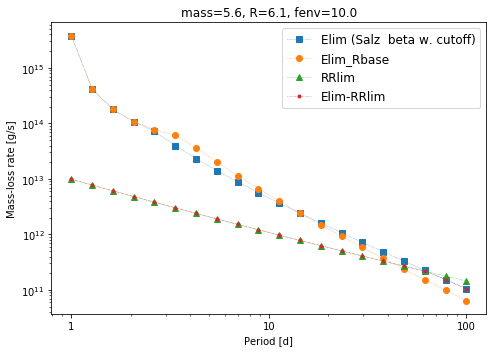

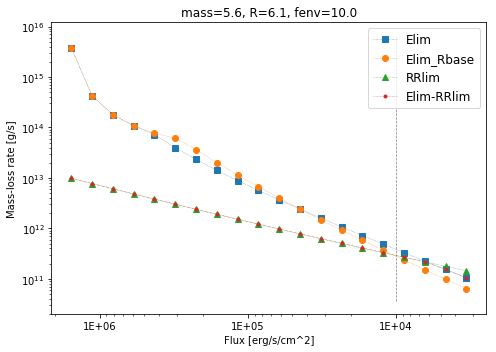

In [22]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_title("mass={:.1f}, R={:.1f}, fenv={:.1f}".format(pl.mass, pl.radius, pl.fenv))
ax.plot(period, -Mdot_Elim_XUV_arr, marker="s", ls=":", lw=0.5, label="Elim (Salz  beta w. cutoff)")
ax.plot(period, -Mdot_Elim_Rbase_RLcut_arr, marker="o", lw=0.5, ls=":", label="Elim_Rbase")
ax.plot(period, -Mdot_RRlim_XUV_arr, marker="^", ls=":", lw=0.5, label="RRlim")
ax.plot(period, -Mdot_ERRlim_XUV_arr, marker=".", ls=":", lw=0.5, label="Elim-RRlim")
#ax.plot(period, -Mdot_HBA_XUV_arr, marker="*", ls=":", lw=0.5, label="HBA (eps=0.15)")
ylim = ax.get_ylim()
#ax.vlines(10, ylim[0], ylim[1], linestyle="--", lw=0.7, color="grey")
ax.set_yscale("log", basey=10); ax.set_xscale("log", basex=10)
ax.legend(fontsize=12)
ax.set_xlabel("Period [d]")
ax.set_ylabel("Mass-loss rate [g/s]")
for axis in [ax.xaxis]: 
    formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y)) 
    axis.set_major_formatter(formatter)
plt.tight_layout();

fig, ax = plt.subplots(figsize=(7,5))
ax.set_title("mass={:.1f}, R={:.1f}, fenv={:.1f}".format(pl.mass, pl.radius, pl.fenv))
ax.plot(F_XUV_arr, -Mdot_Elim_XUV_arr, marker="s", ls=":", lw=0.5, label="Elim")
ax.plot(F_XUV_arr, -Mdot_Elim_Rbase_RLcut_arr, marker="o", lw=0.5, ls=":", label="Elim_Rbase")
ax.plot(F_XUV_arr, -Mdot_RRlim_XUV_arr, marker="^", ls=":", lw=0.5, label="RRlim")
ax.plot(F_XUV_arr, -Mdot_ERRlim_XUV_arr, marker=".", ls=":", lw=0.5, label="Elim-RRlim")
#ax.plot(F_XUV_arr, -Mdot_HBA_XUV_arr, marker="*", ls=":", lw=0.5, label="HBA (eps=0.15)")

ax.set_yscale("log", basey=10)
ax.set_xscale("log", basex=10)

ylim = ax.get_ylim()
xlim = ax.get_xlim()
ax.set_xlim(xlim[1], xlim[0])
ax.vlines(1e4, ylim[0], ylim[1], linestyle="--", lw=0.7, color="grey")

ax.legend(fontsize=12)
ax.set_xlabel("Flux [erg/s/cm^2]")
ax.set_ylabel("Mass-loss rate [g/s]")
for axis in [ax.xaxis]: 
    formatter = FuncFormatter(lambda y, _: '{:.0E}'.format(y)) 
    axis.set_major_formatter(formatter)
plt.tight_layout();

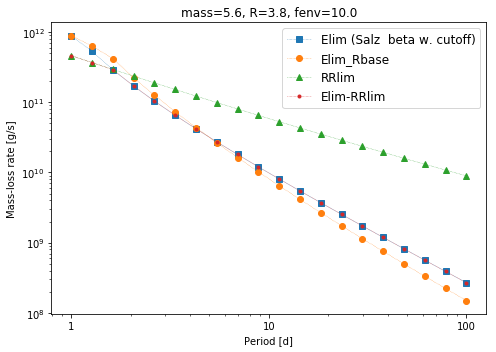

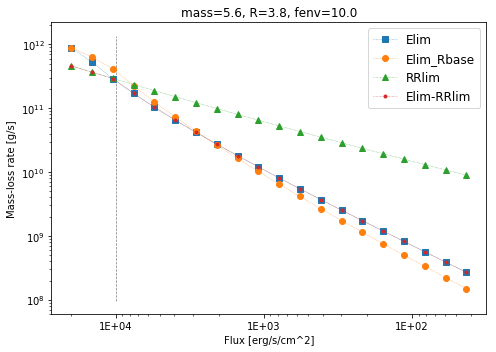

In [18]:
fig, ax = plt.subplots(figsize=(7,5))
ax.set_title("mass={:.1f}, R={:.1f}, fenv={:.1f}".format(pl.mass, pl.radius, pl.fenv))
ax.plot(period, -Mdot_Elim_XUV_arr, marker="s", ls=":", lw=0.5, label="Elim (Salz  beta w. cutoff)")
ax.plot(period, -Mdot_Elim_Rbase_RLcut_arr, marker="o", lw=0.5, ls=":", label="Elim_Rbase")
ax.plot(period, -Mdot_RRlim_XUV_arr, marker="^", ls=":", lw=0.5, label="RRlim")
ax.plot(period, -Mdot_ERRlim_XUV_arr, marker=".", ls=":", lw=0.5, label="Elim-RRlim")
#ax.plot(period, -Mdot_HBA_XUV_arr, marker="*", ls=":", lw=0.5, label="HBA (eps=0.15)")
ylim = ax.get_ylim()
#ax.vlines(10, ylim[0], ylim[1], linestyle="--", lw=0.7, color="grey")
ax.set_yscale("log", basey=10); ax.set_xscale("log", basex=10)
ax.legend(fontsize=12)
ax.set_xlabel("Period [d]")
ax.set_ylabel("Mass-loss rate [g/s]")
for axis in [ax.xaxis]: 
    formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y)) 
    axis.set_major_formatter(formatter)
plt.tight_layout();

fig, ax = plt.subplots(figsize=(7,5))
ax.set_title("mass={:.1f}, R={:.1f}, fenv={:.1f}".format(pl.mass, pl.radius, pl.fenv))
ax.plot(F_XUV_arr, -Mdot_Elim_XUV_arr, marker="s", ls=":", lw=0.5, label="Elim")
ax.plot(F_XUV_arr, -Mdot_Elim_Rbase_RLcut_arr, marker="o", lw=0.5, ls=":", label="Elim_Rbase")
ax.plot(F_XUV_arr, -Mdot_RRlim_XUV_arr, marker="^", ls=":", lw=0.5, label="RRlim")
ax.plot(F_XUV_arr, -Mdot_ERRlim_XUV_arr, marker=".", ls=":", lw=0.5, label="Elim-RRlim")
#ax.plot(F_XUV_arr, -Mdot_HBA_XUV_arr, marker="*", ls=":", lw=0.5, label="HBA (eps=0.15)")

ax.set_yscale("log", basey=10)
ax.set_xscale("log", basex=10)

ylim = ax.get_ylim()
xlim = ax.get_xlim()
ax.set_xlim(xlim[1], xlim[0])
ax.vlines(1e4, ylim[0], ylim[1], linestyle="--", lw=0.7, color="grey")

ax.legend(fontsize=12)
ax.set_xlabel("Flux [erg/s/cm^2]")
ax.set_ylabel("Mass-loss rate [g/s]")
for axis in [ax.xaxis]: 
    formatter = FuncFormatter(lambda y, _: '{:.0E}'.format(y)) 
    axis.set_major_formatter(formatter)
plt.tight_layout();

# TESTING

In [41]:
L_bol, mass_star, radius_star = 1., 1., 1.
age_star = 10. # Myr
Lx_age = Lx_chandra = 1.0e30  # erg/s in energy band: (0.1-2.4 keV)

# use dictionary to store star-parameters
star = {'star_id': 'dummy', 'mass': mass_star,
        'radius': radius_star, 'age': age_star,
        'L_bol': L_bol, 'Lx_age': Lx_age}

Lx_1Gyr, Lx_5Gyr = 2.10*10**28, 1.65*10**27
track_low = {"t_start": star["age"], "t_sat": star["age"],
             "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age, 
             "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 20.,
             "Lx_drop_factor": 16.}
track_med = {"t_start": star["age"], "t_sat": star["age"],
             "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age,
             "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0.,
             "Lx_drop_factor": 0.}
track_high = {"t_start": star["age"], "t_sat": 240., "t_curr": 1000.,
              "t_5Gyr": 5000., "Lx_max": Lx_age, "Lx_curr": Lx_1Gyr,
              "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0., "Lx_drop_factor": 0.}

M_env = 1e-1
M_core = 10.0
M_pl = M_env + M_core
fenv = (M_env / (M_env + M_core))*100

# LoFo14 planet
planet = {"core_mass": M_core, "fenv": fenv,
          "distance": 0.05, "metallicity": "solarZ"}
pl = Planet_LoFo14(star, planet)
planet = {"core_mass": M_core, "fenv": fenv,
          "distance": 0.05, "core_comp": "rock"}
pl = Planet_ChRo16(star, planet)

#planet = {"mass": M_pl, "distance": 0.05}
#pl = Planet_Ot20(star, planet)
print(type(pl))
print("LoFo14: ", isinstance(pl, Planet_LoFo14))
print("ChRo16: ", isinstance(pl, Planet_ChRo16))
print("Ot20:   ", isinstance(pl, Planet_Ot20))

pl.radius, plmoOt20.calculate_mass_planet_Ot20(2.15)

<class 'platypos.planet_ChRo16.Planet_ChRo16'>
LoFo14:  False
ChRo16:  True
Ot20:    False


(2.7324873957971985, 5.831791854389194)

In [42]:
%%time

folder_id = "dummy"
directory = os.getcwd() + "/" + folder_id +"/"

if not os.path.exists(directory):
    os.makedirs(directory)
else:
    os.system("rm -r " + directory[:-1])
    os.makedirs(directory)

t_final = 1e3
pl.evolve_forward_and_create_full_output(t_final,
                                         0.1,
                                         0.1,
                                         "yes",
                                         "yes_Lo17",
                                         track_high,
                                         directory,
                                         folder_id,
                                         beta_cutoff=True,
                                         relation_EUV="Linsky",
                                         mass_loss_calc="Elim_and_RRlim")

CPU times: user 7.51 s, sys: 7.98 ms, total: 7.52 s
Wall time: 7.53 s


In [5]:
M = 10.000000023430122
R = 3.0245815462498804
pl.core_mass, pl.core_radius

M_env = M - pl.core_mass
fenv = (M_env/M)*100.
print(fenv)

2.3430121787796492e-07


In [5]:
df_pl = pl.read_results(directory)
df_pl.head(), df_pl.tail()

(   Time       Mass    Radius            Lx
 0  10.0  10.100000  3.034974  1.000000e+30
 1  10.1  10.099780  3.031993  1.000000e+30
 2  10.2  10.099561  3.029034  1.000000e+30
 3  10.3  10.099343  3.026098  1.000000e+30
 4  10.4  10.099126  3.023183  1.000000e+30,
         Time       Mass    Radius            Lx
 1062  116.20  10.000041  1.787998  1.000000e+30
 1063  116.30  10.000007  1.781646  1.000000e+30
 1064  116.31  10.000003  1.780519  1.000000e+30
 1065  116.32  10.000000  1.778398  1.000000e+30
 1066  116.33  10.000000  1.778279  1.000000e+30)

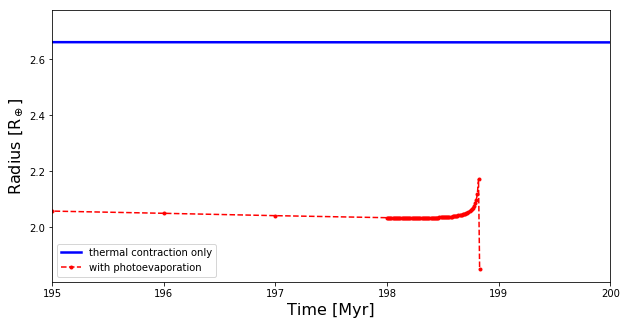

In [49]:
fig, ax = plt.subplots(figsize=(10,5))
age_arr = np.logspace(np.log10(pl.age), np.log10(t_final), 100)

if (type(pl) == Planet_LoFo14):
    ax.plot(age_arr, plmoLoFo14.calculate_planet_radius(pl.core_mass, pl.fenv, age_arr, pl.flux, pl.metallicity), \
            lw=2.5, label='thermal contraction only', color="blue")
elif (type(pl) == Planet_ChRo16):
     ax.plot(age_arr, plmoChRo16.calculate_planet_radius(pl.core_mass, pl.fenv, pl.flux,age_arr, pl.core_comp), \
            lw=2.5, label='thermal contraction only', color="blue")
    
ax.plot(df_pl["Time"], df_pl["Radius"], 
        marker=".", ls="--", label='with photoevaporation', color="red")
#else:
#    ax.plot(df_pl["Time"], df_pl["Radius"], marker="None", ls="--", label='with photoevaporation', color="red")

ax.legend(fontsize=10)
ax.set_xlabel("Time [Myr]", fontsize=16)
ax.set_ylabel("Radius [R$_\oplus$]", fontsize=16)
#ax.set_xscale('log')
#ax.set_xlim(100.,120)
ax.set_xlim(195.,200)
#ax.set_ylim(5.15, 5.62)
plt.show()

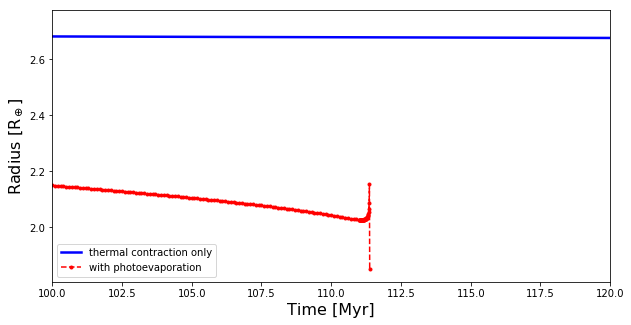

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
age_arr = np.logspace(np.log10(pl.age), np.log10(t_final), 100)

if (type(pl) == Planet_LoFo14):
    ax.plot(age_arr, plmoLoFo14.calculate_planet_radius(pl.core_mass, pl.fenv, age_arr, pl.flux, pl.metallicity), \
            lw=2.5, label='thermal contraction only', color="blue")
elif (type(pl) == Planet_ChRo16):
     ax.plot(age_arr, plmoChRo16.calculate_planet_radius(pl.core_mass, pl.fenv, pl.flux,age_arr, pl.core_comp), \
            lw=2.5, label='thermal contraction only', color="blue")
    
ax.plot(df_pl["Time"], df_pl["Radius"], 
        marker=".", ls="--", label='with photoevaporation', color="red")
#else:
#    ax.plot(df_pl["Time"], df_pl["Radius"], marker="None", ls="--", label='with photoevaporation', color="red")

ax.legend(fontsize=10)
ax.set_xlabel("Time [Myr]", fontsize=16)
ax.set_ylabel("Radius [R$_\oplus$]", fontsize=16)
#ax.set_xscale('log')
ax.set_xlim(100.,120)
#ax.set_ylim(5.15, 5.62)
plt.show()

# V1298 Tau example

In [20]:
# Stellar Parameters:
# -------------------
# (David et al. 2019, Chandra observation)
L_bol, mass_star, radius_star = 0.934, 1.101, 1.345 # solar units
age_star = 23. # Myr
Lx_age = Lx_chandra = 1.3e30  # erg/s in energy band: (0.1-2.4 keV)
Lx_age_error = 1.4e29
# use dictionary to store star-parameters
star_V1298Tau = {'star_id': 'V1298Tau', 'mass': mass_star, 'radius': radius_star, 'age': age_star, 'L_bol': L_bol, 'Lx_age': Lx_age}


# Lx evolutionary tracks:
# -----------------------
# create dictionaries with all the values necessary to define the evolutionary paths (this is done by the function Lx_evo)
# this includes: starting age, age until Lx is saturated, two fixed ages at 1 & 5 Gyr which are set by the Tu et al. (2015) model tracks, 
# and (if wanted) a time interval in which and factor by which Lx drops (if you want a to mimic a track which drops fast early and then levels out).
Lx_1Gyr, Lx_5Gyr = 2.10*10**28, 1.65*10**27  # Lx value at 1 and 5 Gyr from Tu et al. (2015) model tracks

# use dictionaries to store track-parameters
track1 = {"t_start": star_V1298Tau["age"], "t_sat": 240., "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0., "Lx_drop_factor": 0.}
track2 = {"t_start": star_V1298Tau["age"], "t_sat": star_V1298Tau["age"], "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0., "Lx_drop_factor": 0.}
track3 = {"t_start": star_V1298Tau["age"], "t_sat": star_V1298Tau["age"], "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 20., "Lx_drop_factor": 16.}
list_tracks = [track1, track2, track3]

# these are the tracks which use the upper and lower value of the current Lx
track1_lower = track1.copy()
track1_lower["Lx_max"] = Lx_age-Lx_age_error
track2_lower = track2.copy()
track2_lower["Lx_max"] = Lx_age-Lx_age_error
track3_lower = track3.copy()
track3_lower["Lx_max"] = Lx_age-Lx_age_error
list_tracks_lower = [track1_lower, track2_lower, track3_lower]

track1_upper = track1.copy()
track1_upper["Lx_max"] = Lx_age+Lx_age_error
track2_upper = track2.copy()
track2_upper["Lx_max"] = Lx_age+Lx_age_error
track3_upper = track3.copy()
track3_upper["Lx_max"] = Lx_age+Lx_age_error
list_tracks_upper = [track1_upper, track2_upper, track3_upper]

# additional tracks could look like this (different t_sat)
#track2_2 = {"t_start": star_V1298Tau["age"], "t_sat": 70., "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 20., "Lx_drop_factor": 5.}
#track2_3 = {"t_start": star_V1298Tau["age"], "t_sat": 100., "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age, "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0., "Lx_drop_factor": 0.}


# Observed planet parameters 
# --------------------------
# radius R, semi-major axis a and period P from David et al. (2019)
pl_params = pd.read_csv("../supplementary_files/V1298Tau_planet_parameters.csv", index_col=0)

R_c, R_d, R_b, R_e = pl_params.loc["planet_c"].radius, pl_params.loc["planet_d"].radius, pl_params.loc["planet_b"].radius, pl_params.loc["planet_e"].radius
a_c, a_d, a_b, a_e = pl_params.loc["planet_c"].a, pl_params.loc["planet_d"].a, pl_params.loc["planet_b"].a, pl_params.loc["planet_e"].a
P_c, P_d, P_b, P_e = pl_params.loc["planet_c"].period, pl_params.loc["planet_d"].period, pl_params.loc["planet_b"].period, pl_params.loc["planet_e"].period
pl_params.head()

,radius,a,period
planet_c,5.59,0.0825,8.24958
planet_d,6.41,0.1083,12.40320
planet_b,10.27,0.1688,24.13960
planet_e,8.74,0.3080,60.00000


# Create Planet object and stellar evolutionary track

## Example planet 1.1 - V1298Tau c with 5 Eearth mass core and measured radius (var. step)

In [2]:
# (David et al. 2019, Chandra observation)
L_bol, mass_star, radius_star = 0.934, 1.101, 1.345 # solar units
age_star = 23. # Myr
Lx_age = Lx_chandra = 1.3e30  # erg/s in energy band: (0.1-2.4 keV)
Lx_age_error = 1.4e29

# use dictionary to store star-parameters
star_V1298Tau = {'star_id': 'V1298Tau', 'mass': mass_star, 'radius': radius_star, 'age': age_star, 'L_bol': L_bol, 'Lx_age': Lx_age}

Lx_1Gyr, Lx_5Gyr = 2.10*10**28, 1.65*10**27
track_low = {"t_start": star_V1298Tau["age"], "t_sat": star_V1298Tau["age"], "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age, 
         "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 20., "Lx_drop_factor": 16.}
track_med = {"t_start": star_V1298Tau["age"], "t_sat": star_V1298Tau["age"], "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age, 
         "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0., "Lx_drop_factor": 0.}
track_high = {"t_start": star_V1298Tau["age"], "t_sat": 240., "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age, 
         "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0., "Lx_drop_factor": 0.}

# planet c
planet = {"core_mass": 5.0, "radius": 5.59, "distance": 0.0825, "metallicity": "solarZ"}

pl = Planet_LoFo14(star_V1298Tau, planet)
pl.__dict__

{'star_id': 'V1298Tau',
 'mass_star': 1.101,
 'radius_star': 1.345,
 'age': 23.0,
 'Lbol': 3.5753520000000005e+33,
 'Lx_age': 1.3e+30,
 'Lx_sat_info': None,
 'distance': 0.0825,
 'metallicity': 'solarZ',
 'flux': 136.04409090618665,
 't_eq': 952.6201533930437,
 'has_evolved': False,
 'planet_id': 'dummy',
 'planet_info': 'Case 2 - obs. planet with radius, but no mass measurement',
 'core_mass': 5.0,
 'radius': 5.59,
 'core_radius': 1.4953487812212205,
 'fenv': 7.42119964332844,
 'mass': 5.4008044830316075,
 'density': 0.16990523970140295,
 'grav_potential': -603799923496.6542,
 'lambda_escape': 7.682886103221436,
 'radius_RL': 32.891061993434235}

### Example planet 1.1.1 - V1298Tau c with 5 Eearth mass core and measured radius (fixed step)

In [6]:
pl = Planet_LoFo14_PAPER(star_V1298Tau, planet)

## Example planet 1.2 - V1298Tau c with mass estimate from Otegi et al. (2020) and measured radius (var step)

In [3]:
pl = Planet_Ot20(star_V1298Tau, planet)
pl.__dict__

{'star_id': 'V1298Tau',
 'mass_star': 1.101,
 'radius_star': 1.345,
 'age': 23.0,
 'Lbol': 3.5753520000000005e+33,
 'Lx_age': 1.3e+30,
 'distance': 0.0825,
 'flux': 136.04409090618665,
 'has_evolved': False,
 'planet_id': 'dummy',
 'radius': 5.59,
 'mass': 26.391246598963903,
 'Lx_sat_info': None}

### Example planet 1.2.1 - V1298Tau c with mass estimate from Otegi et al. (2020) and measured radius (fixed step)

In [7]:
pl = Planet_Ot20_PAPER(star_V1298Tau, planet)
pl.__dict__

{'star_id': 'V1298Tau',
 'mass_star': 1.101,
 'radius_star': 1.345,
 'age': 23.0,
 'Lbol': 3.5753520000000005e+33,
 'Lx_age': 1.3e+30,
 'distance': 0.0825,
 'flux': 136.04409090618665,
 'has_evolved': False,
 'planet_id': 'dummy',
 'radius': 5.59,
 'mass': 26.391246598963903,
 'Lx_sat_info': None}

## Example planet 2 - artificial planet with specified core mass and envelope mass fraction

In [12]:
Lx_1Gyr, Lx_5Gyr = 2.10*10**28, 1.65*10**27

dict_star = {'star_id': 'star_age1.0_mass0.89',
 'mass': 0.8879632311581124,
 'radius': None,
 'age': 1.0,
 'L_bol': 1.9992811847525246e+33/const.L_sun.cgs.value,
 'Lx_age': 1.298868513129789e+30}

dict_pl = {'distance': 0.12248611607793611,
 'metallicity': 'solarZ',
'fenv': 3.7544067802231664,
 'core_mass': 4.490153906104026}

track = {"t_start": dict_star["age"], "t_sat": 100., "t_curr": 1000., "t_5Gyr": 5000., "Lx_max": Lx_age, 
         "Lx_curr": Lx_1Gyr, "Lx_5Gyr": Lx_5Gyr, "dt_drop": 0., "Lx_drop_factor": 0.}

pl = Planet_LoFo14(dict_star, dict_pl)
#pl.__dict__

# Evolve & create outputs

In [34]:
planet_c = {"core_mass": 5.0, "radius": R_c, "distance": a_c, "metallicity": "solarZ"}
planet_d = {"core_mass": 5.0, "radius": R_d, "distance": a_d, "metallicity": "solarZ"}
planet_b = {"core_mass": 5.0, "radius": R_b, "distance": a_b, "metallicity": "solarZ"}
planet_e = {"core_mass": 5.0, "radius": R_e, "distance": a_e, "metallicity": "solarZ"}

# variable step size
pl_c_5 = Planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_c)
pl_d_5 = Planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_d)
pl_b_5 = Planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_b)
pl_e_5 = Planet_LoFo14(star_dictionary=star_V1298Tau, planet_dict=planet_e)
planet_list_Mcore5 = [pl_c_5, pl_d_5, pl_b_5, pl_e_5]

pl = planet_list_Mcore5[0]
pl.distance

0.0825

In [38]:
%%time

folder_id = "dummy"
path_save = os.getcwd() + "/" + folder_id +"/"
if not os.path.exists(path_save):
    os.makedirs(path_save)
else:
    os.system("rm -r " + path_save[:-1])
    os.makedirs(path_save)

t_final = 5007.
pl.evolve_forward_and_create_full_output(t_final,
                                         0.1,
                                         0.1,
                                         "yes",
                                         "yes",
                                         track1,
                                         path_save,
                                         folder_id,
                                         beta_cutoff=True,
                                         relation_EUV="SanzFo",
                                         mass_loss_calc="Elim")

CPU times: user 29.1 s, sys: 3.99 ms, total: 29.1 s
Wall time: 29.1 s


# Read in results and plot

In [39]:
df_pl = pl.read_results(path_save)
df_pl.head(), df_pl.tail()

(    Time      Mass    Radius            Lx
 0  23.00  5.400804  5.590000  1.300000e+30
 1  23.01  5.400148  5.586243  1.300000e+30
 2  23.02  5.399493  5.582491  1.300000e+30
 3  23.03  5.398839  5.578743  1.300000e+30
 4  23.04  5.398186  5.575000  1.300000e+30,
        Time      Mass    Radius            Lx
 3287  55.87  5.000033  1.510833  1.300000e+30
 3288  55.88  5.000025  1.508341  1.300000e+30
 3289  55.89  5.000016  1.505477  1.300000e+30
 3290  55.90  5.000008  1.501907  1.300000e+30
 3291  55.91  5.000000  1.495349  1.300000e+30)

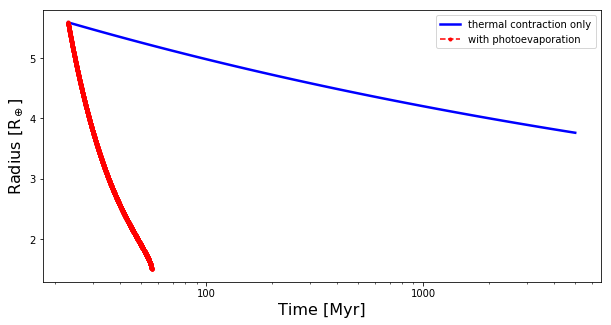

In [40]:
fig, ax = plt.subplots(figsize=(10,5))
age_arr = np.logspace(np.log10(pl.age), np.log10(t_final), 100)

if (type(pl) == Planet_LoFo14):
    ax.plot(age_arr, plmoLoFo14.calculate_planet_radius(pl.core_mass, pl.fenv, age_arr, pl.flux, pl.metallicity), \
            lw=2.5, label='thermal contraction only', color="blue")
elif (type(pl) == Planet_ChRo16):
     ax.plot(age_arr, plmoChRo16.calculate_planet_radius(pl.core_mass, pl.fenv, pl.flux,age_arr, pl.core_comp), \
            lw=2.5, label='thermal contraction only', color="blue")
    
ax.plot(df_pl["Time"], df_pl["Radius"], 
        marker=".", ls="--", label='with photoevaporation', color="red")

ax.legend(fontsize=10)
ax.set_xlabel("Time [Myr]", fontsize=16)
ax.set_ylabel("Radius [R$_\oplus$]", fontsize=16)
ax.set_xscale('log')
#ax.set_ylim(5.15, 5.62)
for axis in [ax.xaxis]: 
    formatter = FuncFormatter(lambda y, _: '{:.16g}'.format(y)) 
    axis.set_major_formatter(formatter)
plt.show()